# Profile original VGAE (Kipf & Welling 2016)

In [1]:
import time
import random
import os

import numpy as np
import scipy.sparse as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from nw2vec import viz

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.input_data import load_data
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

Using TensorFlow backend.


In [2]:
random.seed(1)
np.random.seed(1)

### Model drawing routines

In [3]:
def plot_ξ_distribution(glk, z_mean):
    g, l, k = glk
    palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
                              .5 * np.ones((l, 1))],
                             axis=1)
    communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)
    fig, ax = plt.subplots(figsize=(6, 4))

    # μ plots
    ax.scatter(z_mean[:, 0], z_mean[:, 1], s=250, c=palette[communities])
    for i, (x, y) in enumerate(z_mean):
        ax.text(x, y, str(i), ha='center', va='center', color='white')
    ax.set_title(r'$\mu = \left<\xi\right>$ for each node')

## Test graphs

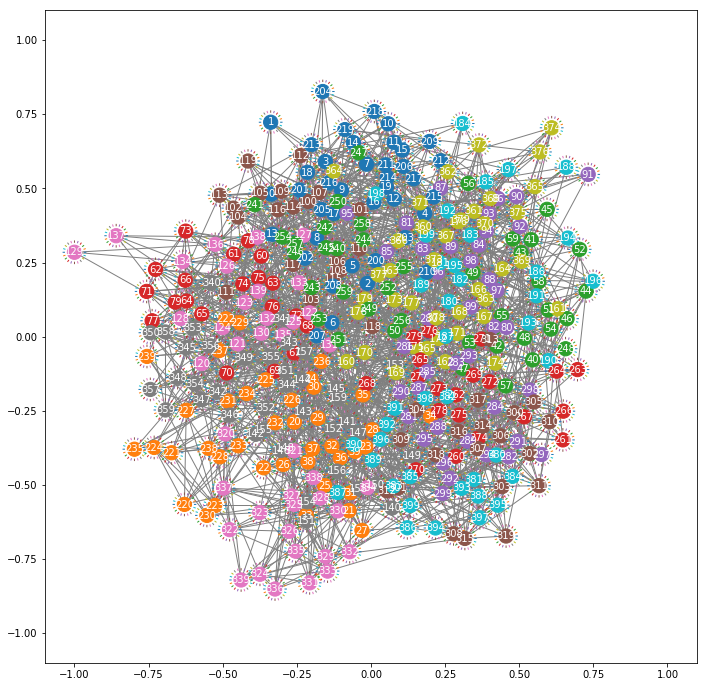

In [4]:
# Parameters
l = 20
k = 20
p_in = .4
p_out = .01
g = nx.planted_partition_graph(l, k, p_in, p_out)

# Show the graph
labels = np.zeros((l * k, l), dtype=np.float32)
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
features = labels + np.abs(np.random.normal(loc=0.0, scale=.2, size=(l * k, l))).astype(np.float32)
viz.draw_network(g, labels=features);

## Set up GAE

In [5]:
# Set options and move to necessary directory for data loading
MODEL_STRING = 'gcn_vae'
os.chdir('../../gae')

In [6]:
# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('hidden1', 10, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 2, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', MODEL_STRING, 'Model string.')
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

# Workaround for Jupyter having an '-f' flag in its sys.argv -- this is ignored
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [7]:
model_str = FLAGS.model
dataset_str = FLAGS.dataset

# Load data
adj = nx.adjacency_matrix(g).astype(np.float32)

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

if FLAGS.features == 0:
    features = sp.identity(features.shape[0])  # featureless

# Some preprocessing
adj_norm = preprocess_graph(adj)

# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

num_nodes = adj.shape[0]

features = sparse_to_tuple(sp.csr_matrix(features).tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

In [8]:
# Create model
model = None
if model_str == 'gcn_ae':
    model = GCNModelAE(placeholders, num_features, features_nonzero)
elif model_str == 'gcn_vae':
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):
    if model_str == 'gcn_ae':
        opt = OptimizerAE(preds=model.reconstructions,
                          labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                      validate_indices=False), [-1]),
                          pos_weight=pos_weight,
                          norm=norm)
    elif model_str == 'gcn_vae':
        opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm)

In [9]:
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [10]:
# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

cost_val = []
acc_val = []
val_roc_score = []

adj_label = adj + sp.eye(adj.shape[0])
adj_label = sparse_to_tuple(adj_label)

### Interlude: embeddings before training

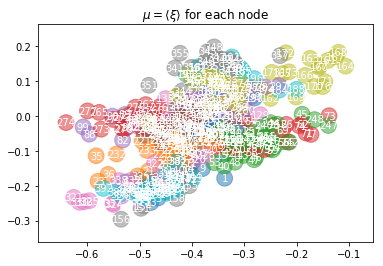

In [11]:
feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
feed_dict.update({placeholders['dropout']: 0})
emb = sess.run(model.z_mean, feed_dict=feed_dict)
plot_ξ_distribution((g, l, k), emb)

### Back to training

In [12]:
def train(nepochs):
    for epoch in range(nepochs):

        t = time.time()
        # Construct feed dictionary
        feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
        feed_dict.update({placeholders['dropout']: FLAGS.dropout})
        # Run single weight update
        outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

        # Compute average loss
        avg_cost = outs[1]
        avg_accuracy = outs[2]

        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
              "train_acc=", "{:.5f}".format(avg_accuracy),
              "time=", "{:.5f}".format(time.time() - t))

    print("Optimization Finished!")

In [13]:
n_epochs = 1000
with tf.contrib.tfprof.ProfileContext('./gae_train_dir') as pctx:
    train(n_epochs)

Epoch: 0001 train_loss= 0.94403 train_acc= 0.44541 time= 0.13198
Epoch: 0002 train_loss= 0.86920 train_acc= 0.44944 time= 0.00730
Epoch: 0003 train_loss= 0.83915 train_acc= 0.47564 time= 0.00526
Epoch: 0004 train_loss= 0.80399 train_acc= 0.47874 time= 0.01002
Epoch: 0005 train_loss= 0.77499 train_acc= 0.47300 time= 0.01056
Epoch: 0006 train_loss= 0.75412 train_acc= 0.49020 time= 0.01990
Epoch: 0007 train_loss= 0.74969 train_acc= 0.48379 time= 0.00544
Epoch: 0008 train_loss= 0.74498 train_acc= 0.47605 time= 0.00673
Epoch: 0009 train_loss= 0.73835 train_acc= 0.49931 time= 0.00725
Epoch: 0010 train_loss= 0.73248 train_acc= 0.48761 time= 0.00938
Epoch: 0011 train_loss= 0.73010 train_acc= 0.49738 time= 0.00640


153 ops no flops stats due to incomplete shapes.


Epoch: 0012 train_loss= 0.73426 train_acc= 0.48804 time= 2.09876
Epoch: 0013 train_loss= 0.72476 train_acc= 0.48506 time= 0.01344
Epoch: 0014 train_loss= 0.72602 train_acc= 0.48706 time= 0.00893
Epoch: 0015 train_loss= 0.72603 train_acc= 0.47650 time= 0.01526
Epoch: 0016 train_loss= 0.72845 train_acc= 0.43149 time= 0.01675
Epoch: 0017 train_loss= 0.72443 train_acc= 0.44716 time= 0.00608
Epoch: 0018 train_loss= 0.72300 train_acc= 0.44860 time= 0.00614
Epoch: 0019 train_loss= 0.72534 train_acc= 0.46206 time= 0.00602
Epoch: 0020 train_loss= 0.72163 train_acc= 0.44868 time= 0.00580
Epoch: 0021 train_loss= 0.72316 train_acc= 0.45561 time= 0.00639
Epoch: 0022 train_loss= 0.72281 train_acc= 0.45112 time= 0.00629
Epoch: 0023 train_loss= 0.72391 train_acc= 0.45565 time= 0.00588
Epoch: 0024 train_loss= 0.72146 train_acc= 0.46791 time= 0.00559
Epoch: 0025 train_loss= 0.72213 train_acc= 0.44751 time= 0.01161
Epoch: 0026 train_loss= 0.72179 train_acc= 0.42776 time= 0.08442
Epoch: 0027 train_loss= 0

Epoch: 0140 train_loss= 0.65276 train_acc= 0.52017 time= 0.01621
Epoch: 0141 train_loss= 0.65250 train_acc= 0.51870 time= 0.01907
Epoch: 0142 train_loss= 0.65225 train_acc= 0.51895 time= 0.00769
Epoch: 0143 train_loss= 0.65200 train_acc= 0.52121 time= 0.02376
Epoch: 0144 train_loss= 0.65295 train_acc= 0.51950 time= 0.01972
Epoch: 0145 train_loss= 0.65191 train_acc= 0.51914 time= 0.00569
Epoch: 0146 train_loss= 0.65120 train_acc= 0.51989 time= 0.00510
Epoch: 0147 train_loss= 0.65194 train_acc= 0.52108 time= 0.00519
Epoch: 0148 train_loss= 0.65160 train_acc= 0.51960 time= 0.00482
Epoch: 0149 train_loss= 0.65116 train_acc= 0.51860 time= 0.00498
Epoch: 0150 train_loss= 0.65066 train_acc= 0.52005 time= 0.00503
Epoch: 0151 train_loss= 0.65114 train_acc= 0.52068 time= 0.00516
Epoch: 0152 train_loss= 0.65153 train_acc= 0.52040 time= 0.00503
Epoch: 0153 train_loss= 0.65055 train_acc= 0.51984 time= 0.00508
Epoch: 0154 train_loss= 0.65080 train_acc= 0.51924 time= 0.00541
Epoch: 0155 train_loss= 0

Epoch: 0273 train_loss= 0.61087 train_acc= 0.52610 time= 0.05881
Epoch: 0274 train_loss= 0.61026 train_acc= 0.52403 time= 0.01668
Epoch: 0275 train_loss= 0.61089 train_acc= 0.52616 time= 0.04411
Epoch: 0276 train_loss= 0.60978 train_acc= 0.52805 time= 0.03127
Epoch: 0277 train_loss= 0.60955 train_acc= 0.52662 time= 0.04041
Epoch: 0278 train_loss= 0.61094 train_acc= 0.52569 time= 0.04402
Epoch: 0279 train_loss= 0.60973 train_acc= 0.52409 time= 0.05147
Epoch: 0280 train_loss= 0.60956 train_acc= 0.52817 time= 0.01854
Epoch: 0281 train_loss= 0.61031 train_acc= 0.52632 time= 0.00566
Epoch: 0282 train_loss= 0.61001 train_acc= 0.52539 time= 0.03912
Epoch: 0283 train_loss= 0.60930 train_acc= 0.52626 time= 0.00740
Epoch: 0284 train_loss= 0.60896 train_acc= 0.52734 time= 0.00608
Epoch: 0285 train_loss= 0.60939 train_acc= 0.52503 time= 0.00746
Epoch: 0286 train_loss= 0.60986 train_acc= 0.52684 time= 0.02620
Epoch: 0287 train_loss= 0.60931 train_acc= 0.52626 time= 0.06775
Epoch: 0288 train_loss= 0

Epoch: 0402 train_loss= 0.60438 train_acc= 0.53237 time= 0.04332
Epoch: 0403 train_loss= 0.60457 train_acc= 0.53005 time= 0.01729
Epoch: 0404 train_loss= 0.60507 train_acc= 0.53164 time= 0.00587
Epoch: 0405 train_loss= 0.60449 train_acc= 0.52917 time= 0.00554
Epoch: 0406 train_loss= 0.60484 train_acc= 0.52933 time= 0.03037
Epoch: 0407 train_loss= 0.60479 train_acc= 0.53427 time= 0.00843
Epoch: 0408 train_loss= 0.60450 train_acc= 0.53039 time= 0.00546
Epoch: 0409 train_loss= 0.60479 train_acc= 0.53044 time= 0.01628
Epoch: 0410 train_loss= 0.60433 train_acc= 0.53088 time= 0.01413
Epoch: 0411 train_loss= 0.60413 train_acc= 0.53233 time= 0.01467
Epoch: 0412 train_loss= 0.60439 train_acc= 0.52746 time= 0.02504
Epoch: 0413 train_loss= 0.60487 train_acc= 0.53111 time= 0.03045
Epoch: 0414 train_loss= 0.60433 train_acc= 0.53118 time= 0.02982
Epoch: 0415 train_loss= 0.60429 train_acc= 0.53057 time= 0.02697
Epoch: 0416 train_loss= 0.60462 train_acc= 0.53251 time= 0.01863
Epoch: 0417 train_loss= 0

Epoch: 0530 train_loss= 0.60102 train_acc= 0.52884 time= 0.00871
Epoch: 0531 train_loss= 0.60155 train_acc= 0.52828 time= 0.00610
Epoch: 0532 train_loss= 0.60119 train_acc= 0.52699 time= 0.02385
Epoch: 0533 train_loss= 0.60136 train_acc= 0.52876 time= 0.00872
Epoch: 0534 train_loss= 0.60134 train_acc= 0.52702 time= 0.02497
Epoch: 0535 train_loss= 0.60139 train_acc= 0.53004 time= 0.02203
Epoch: 0536 train_loss= 0.60178 train_acc= 0.52774 time= 0.03973
Epoch: 0537 train_loss= 0.60070 train_acc= 0.52701 time= 0.03974
Epoch: 0538 train_loss= 0.60094 train_acc= 0.52671 time= 0.03153
Epoch: 0539 train_loss= 0.60138 train_acc= 0.52567 time= 0.03705
Epoch: 0540 train_loss= 0.60147 train_acc= 0.52903 time= 0.00612
Epoch: 0541 train_loss= 0.60096 train_acc= 0.52807 time= 0.00596
Epoch: 0542 train_loss= 0.60072 train_acc= 0.52767 time= 0.00594
Epoch: 0543 train_loss= 0.60117 train_acc= 0.52505 time= 0.00934
Epoch: 0544 train_loss= 0.60072 train_acc= 0.52718 time= 0.00524
Epoch: 0545 train_loss= 0

Epoch: 0659 train_loss= 0.59852 train_acc= 0.53395 time= 0.03729
Epoch: 0660 train_loss= 0.59859 train_acc= 0.53377 time= 0.02294
Epoch: 0661 train_loss= 0.59877 train_acc= 0.53119 time= 0.00688
Epoch: 0662 train_loss= 0.59898 train_acc= 0.53478 time= 0.02217
Epoch: 0663 train_loss= 0.59896 train_acc= 0.53236 time= 0.03928
Epoch: 0664 train_loss= 0.59836 train_acc= 0.53461 time= 0.00727
Epoch: 0665 train_loss= 0.59870 train_acc= 0.53220 time= 0.02611
Epoch: 0666 train_loss= 0.59773 train_acc= 0.53284 time= 0.01901
Epoch: 0667 train_loss= 0.59856 train_acc= 0.53309 time= 0.01304
Epoch: 0668 train_loss= 0.59835 train_acc= 0.53439 time= 0.01125
Epoch: 0669 train_loss= 0.59850 train_acc= 0.53637 time= 0.02110
Epoch: 0670 train_loss= 0.59874 train_acc= 0.53299 time= 0.01472
Epoch: 0671 train_loss= 0.59868 train_acc= 0.53392 time= 0.01089
Epoch: 0672 train_loss= 0.59825 train_acc= 0.53234 time= 0.01461
Epoch: 0673 train_loss= 0.59843 train_acc= 0.53443 time= 0.01790
Epoch: 0674 train_loss= 0

Epoch: 0790 train_loss= 0.59742 train_acc= 0.53951 time= 0.02293
Epoch: 0791 train_loss= 0.59755 train_acc= 0.53943 time= 0.00514
Epoch: 0792 train_loss= 0.59717 train_acc= 0.53986 time= 0.00604
Epoch: 0793 train_loss= 0.59705 train_acc= 0.53881 time= 0.00529
Epoch: 0794 train_loss= 0.59748 train_acc= 0.53810 time= 0.01345
Epoch: 0795 train_loss= 0.59735 train_acc= 0.54020 time= 0.02142
Epoch: 0796 train_loss= 0.59700 train_acc= 0.53664 time= 0.00578
Epoch: 0797 train_loss= 0.59683 train_acc= 0.53696 time= 0.01129
Epoch: 0798 train_loss= 0.59712 train_acc= 0.53590 time= 0.00856
Epoch: 0799 train_loss= 0.59789 train_acc= 0.54011 time= 0.00551
Epoch: 0800 train_loss= 0.59734 train_acc= 0.53991 time= 0.03424
Epoch: 0801 train_loss= 0.59707 train_acc= 0.53856 time= 0.01564
Epoch: 0802 train_loss= 0.59748 train_acc= 0.54001 time= 0.02003
Epoch: 0803 train_loss= 0.59698 train_acc= 0.54064 time= 0.02146
Epoch: 0804 train_loss= 0.59759 train_acc= 0.54070 time= 0.01057
Epoch: 0805 train_loss= 0

Epoch: 0926 train_loss= 0.59730 train_acc= 0.54416 time= 0.01632
Epoch: 0927 train_loss= 0.59674 train_acc= 0.54677 time= 0.00839
Epoch: 0928 train_loss= 0.59612 train_acc= 0.54610 time= 0.01754
Epoch: 0929 train_loss= 0.59687 train_acc= 0.54803 time= 0.01346
Epoch: 0930 train_loss= 0.59754 train_acc= 0.54331 time= 0.01598
Epoch: 0931 train_loss= 0.59633 train_acc= 0.54280 time= 0.03055
Epoch: 0932 train_loss= 0.59713 train_acc= 0.54760 time= 0.03321
Epoch: 0933 train_loss= 0.59730 train_acc= 0.54663 time= 0.00612
Epoch: 0934 train_loss= 0.59691 train_acc= 0.54766 time= 0.00858
Epoch: 0935 train_loss= 0.59677 train_acc= 0.54706 time= 0.02069
Epoch: 0936 train_loss= 0.59744 train_acc= 0.54787 time= 0.01156
Epoch: 0937 train_loss= 0.59696 train_acc= 0.54620 time= 0.02315
Epoch: 0938 train_loss= 0.59706 train_acc= 0.54411 time= 0.01227
Epoch: 0939 train_loss= 0.59763 train_acc= 0.54386 time= 0.00917
Epoch: 0940 train_loss= 0.59707 train_acc= 0.54629 time= 0.02973
Epoch: 0941 train_loss= 0

In [14]:
import cProfile
n_epochs = 1000#5000
cProfile.run("""train(n_epochs)""", "gae.profile")

Epoch: 0001 train_loss= 0.59652 train_acc= 0.54454 time= 0.01254
Epoch: 0002 train_loss= 0.59623 train_acc= 0.54946 time= 0.00694
Epoch: 0003 train_loss= 0.59720 train_acc= 0.54800 time= 0.01399
Epoch: 0004 train_loss= 0.59674 train_acc= 0.54506 time= 0.00694
Epoch: 0005 train_loss= 0.59634 train_acc= 0.54644 time= 0.00632
Epoch: 0006 train_loss= 0.59628 train_acc= 0.54410 time= 0.02183
Epoch: 0007 train_loss= 0.59630 train_acc= 0.54803 time= 0.00642
Epoch: 0008 train_loss= 0.59675 train_acc= 0.54905 time= 0.01943
Epoch: 0009 train_loss= 0.59621 train_acc= 0.54624 time= 0.00901
Epoch: 0010 train_loss= 0.59663 train_acc= 0.54655 time= 0.02331
Epoch: 0011 train_loss= 0.59678 train_acc= 0.54614 time= 0.01044
Epoch: 0012 train_loss= 0.59615 train_acc= 0.54738 time= 0.02004
Epoch: 0013 train_loss= 0.59667 train_acc= 0.55014 time= 0.01049
Epoch: 0014 train_loss= 0.59600 train_acc= 0.54742 time= 0.01993
Epoch: 0015 train_loss= 0.59644 train_acc= 0.54745 time= 0.01009
Epoch: 0016 train_loss= 0

Epoch: 0132 train_loss= 0.59624 train_acc= 0.54642 time= 0.00678
Epoch: 0133 train_loss= 0.59646 train_acc= 0.54500 time= 0.00914
Epoch: 0134 train_loss= 0.59695 train_acc= 0.54615 time= 0.00640
Epoch: 0135 train_loss= 0.59652 train_acc= 0.54811 time= 0.00623
Epoch: 0136 train_loss= 0.59697 train_acc= 0.54436 time= 0.00615
Epoch: 0137 train_loss= 0.59683 train_acc= 0.54745 time= 0.00588
Epoch: 0138 train_loss= 0.59692 train_acc= 0.54511 time= 0.00552
Epoch: 0139 train_loss= 0.59686 train_acc= 0.54834 time= 0.00551
Epoch: 0140 train_loss= 0.59697 train_acc= 0.54530 time= 0.00564
Epoch: 0141 train_loss= 0.59666 train_acc= 0.54680 time= 0.00544
Epoch: 0142 train_loss= 0.59705 train_acc= 0.54774 time= 0.00555
Epoch: 0143 train_loss= 0.59672 train_acc= 0.54782 time= 0.00564
Epoch: 0144 train_loss= 0.59666 train_acc= 0.54525 time= 0.03874
Epoch: 0145 train_loss= 0.59651 train_acc= 0.54440 time= 0.04352
Epoch: 0146 train_loss= 0.59623 train_acc= 0.54454 time= 0.01620
Epoch: 0147 train_loss= 0

Epoch: 0273 train_loss= 0.59596 train_acc= 0.54303 time= 0.03912
Epoch: 0274 train_loss= 0.59678 train_acc= 0.54341 time= 0.01019
Epoch: 0275 train_loss= 0.59655 train_acc= 0.54576 time= 0.00592
Epoch: 0276 train_loss= 0.59602 train_acc= 0.54581 time= 0.00576
Epoch: 0277 train_loss= 0.59672 train_acc= 0.54430 time= 0.00552
Epoch: 0278 train_loss= 0.59667 train_acc= 0.54473 time= 0.00575
Epoch: 0279 train_loss= 0.59674 train_acc= 0.54480 time= 0.00573
Epoch: 0280 train_loss= 0.59641 train_acc= 0.54440 time= 0.00570
Epoch: 0281 train_loss= 0.59595 train_acc= 0.54476 time= 0.00554
Epoch: 0282 train_loss= 0.59612 train_acc= 0.54123 time= 0.00550
Epoch: 0283 train_loss= 0.59613 train_acc= 0.54411 time= 0.00539
Epoch: 0284 train_loss= 0.59641 train_acc= 0.54430 time= 0.00556
Epoch: 0285 train_loss= 0.59616 train_acc= 0.54216 time= 0.06281
Epoch: 0286 train_loss= 0.59635 train_acc= 0.54359 time= 0.05613
Epoch: 0287 train_loss= 0.59605 train_acc= 0.54654 time= 0.03888
Epoch: 0288 train_loss= 0

Epoch: 0410 train_loss= 0.59617 train_acc= 0.54324 time= 0.00674
Epoch: 0411 train_loss= 0.59595 train_acc= 0.54310 time= 0.00575
Epoch: 0412 train_loss= 0.59696 train_acc= 0.54495 time= 0.02312
Epoch: 0413 train_loss= 0.59587 train_acc= 0.54584 time= 0.01017
Epoch: 0414 train_loss= 0.59615 train_acc= 0.54511 time= 0.01442
Epoch: 0415 train_loss= 0.59608 train_acc= 0.54535 time= 0.02032
Epoch: 0416 train_loss= 0.59645 train_acc= 0.54519 time= 0.03241
Epoch: 0417 train_loss= 0.59633 train_acc= 0.54251 time= 0.00618
Epoch: 0418 train_loss= 0.59636 train_acc= 0.54266 time= 0.00572
Epoch: 0419 train_loss= 0.59627 train_acc= 0.54305 time= 0.03161
Epoch: 0420 train_loss= 0.59602 train_acc= 0.54286 time= 0.03767
Epoch: 0421 train_loss= 0.59615 train_acc= 0.54474 time= 0.04759
Epoch: 0422 train_loss= 0.59645 train_acc= 0.54751 time= 0.01487
Epoch: 0423 train_loss= 0.59623 train_acc= 0.54525 time= 0.00663
Epoch: 0424 train_loss= 0.59654 train_acc= 0.54256 time= 0.00661
Epoch: 0425 train_loss= 0

Epoch: 0539 train_loss= 0.59612 train_acc= 0.54163 time= 0.03980
Epoch: 0540 train_loss= 0.59554 train_acc= 0.54153 time= 0.01566
Epoch: 0541 train_loss= 0.59587 train_acc= 0.54326 time= 0.03793
Epoch: 0542 train_loss= 0.59633 train_acc= 0.54567 time= 0.02650
Epoch: 0543 train_loss= 0.59613 train_acc= 0.54159 time= 0.00687
Epoch: 0544 train_loss= 0.59598 train_acc= 0.54404 time= 0.02329
Epoch: 0545 train_loss= 0.59658 train_acc= 0.53873 time= 0.00750
Epoch: 0546 train_loss= 0.59625 train_acc= 0.54201 time= 0.01990
Epoch: 0547 train_loss= 0.59600 train_acc= 0.54273 time= 0.04347
Epoch: 0548 train_loss= 0.59630 train_acc= 0.54418 time= 0.03673
Epoch: 0549 train_loss= 0.59644 train_acc= 0.54418 time= 0.00603
Epoch: 0550 train_loss= 0.59623 train_acc= 0.54369 time= 0.00547
Epoch: 0551 train_loss= 0.59680 train_acc= 0.54416 time= 0.00546
Epoch: 0552 train_loss= 0.59678 train_acc= 0.54154 time= 0.04070
Epoch: 0553 train_loss= 0.59619 train_acc= 0.54299 time= 0.05558
Epoch: 0554 train_loss= 0

Epoch: 0689 train_loss= 0.59650 train_acc= 0.54189 time= 0.02479
Epoch: 0690 train_loss= 0.59632 train_acc= 0.54120 time= 0.01770
Epoch: 0691 train_loss= 0.59670 train_acc= 0.54195 time= 0.00558
Epoch: 0692 train_loss= 0.59617 train_acc= 0.54174 time= 0.00568
Epoch: 0693 train_loss= 0.59647 train_acc= 0.54247 time= 0.04566
Epoch: 0694 train_loss= 0.59620 train_acc= 0.54408 time= 0.04108
Epoch: 0695 train_loss= 0.59629 train_acc= 0.54175 time= 0.00636
Epoch: 0696 train_loss= 0.59608 train_acc= 0.54132 time= 0.00558
Epoch: 0697 train_loss= 0.59618 train_acc= 0.54285 time= 0.00551
Epoch: 0698 train_loss= 0.59558 train_acc= 0.54206 time= 0.01190
Epoch: 0699 train_loss= 0.59617 train_acc= 0.53966 time= 0.02380
Epoch: 0700 train_loss= 0.59613 train_acc= 0.53796 time= 0.03997
Epoch: 0701 train_loss= 0.59628 train_acc= 0.53971 time= 0.03549
Epoch: 0702 train_loss= 0.59600 train_acc= 0.54182 time= 0.05169
Epoch: 0703 train_loss= 0.59627 train_acc= 0.54450 time= 0.03975
Epoch: 0704 train_loss= 0

Epoch: 0827 train_loss= 0.59595 train_acc= 0.53981 time= 0.00659
Epoch: 0828 train_loss= 0.59627 train_acc= 0.53798 time= 0.00655
Epoch: 0829 train_loss= 0.59598 train_acc= 0.53782 time= 0.00705
Epoch: 0830 train_loss= 0.59621 train_acc= 0.53706 time= 0.00611
Epoch: 0831 train_loss= 0.59588 train_acc= 0.54029 time= 0.00603
Epoch: 0832 train_loss= 0.59585 train_acc= 0.53960 time= 0.00614
Epoch: 0833 train_loss= 0.59620 train_acc= 0.53920 time= 0.02118
Epoch: 0834 train_loss= 0.59684 train_acc= 0.53782 time= 0.00684
Epoch: 0835 train_loss= 0.59605 train_acc= 0.53650 time= 0.00642
Epoch: 0836 train_loss= 0.59623 train_acc= 0.53550 time= 0.00610
Epoch: 0837 train_loss= 0.59612 train_acc= 0.53826 time= 0.01114
Epoch: 0838 train_loss= 0.59589 train_acc= 0.53421 time= 0.00642
Epoch: 0839 train_loss= 0.59605 train_acc= 0.53847 time= 0.00606
Epoch: 0840 train_loss= 0.59573 train_acc= 0.54034 time= 0.00620
Epoch: 0841 train_loss= 0.59686 train_acc= 0.53845 time= 0.03676
Epoch: 0842 train_loss= 0

Epoch: 0962 train_loss= 0.59578 train_acc= 0.53200 time= 0.02362
Epoch: 0963 train_loss= 0.59649 train_acc= 0.53246 time= 0.02070
Epoch: 0964 train_loss= 0.59574 train_acc= 0.53532 time= 0.02619
Epoch: 0965 train_loss= 0.59595 train_acc= 0.53341 time= 0.01064
Epoch: 0966 train_loss= 0.59581 train_acc= 0.52870 time= 0.03567
Epoch: 0967 train_loss= 0.59671 train_acc= 0.53539 time= 0.02566
Epoch: 0968 train_loss= 0.59566 train_acc= 0.53269 time= 0.01732
Epoch: 0969 train_loss= 0.59586 train_acc= 0.53300 time= 0.02959
Epoch: 0970 train_loss= 0.59612 train_acc= 0.53476 time= 0.02081
Epoch: 0971 train_loss= 0.59630 train_acc= 0.53190 time= 0.01367
Epoch: 0972 train_loss= 0.59589 train_acc= 0.53465 time= 0.03364
Epoch: 0973 train_loss= 0.59576 train_acc= 0.53470 time= 0.01508
Epoch: 0974 train_loss= 0.59608 train_acc= 0.53195 time= 0.00603
Epoch: 0975 train_loss= 0.59645 train_acc= 0.53291 time= 0.00918
Epoch: 0976 train_loss= 0.59602 train_acc= 0.53341 time= 0.00851
Epoch: 0977 train_loss= 0

### Embeddings after training

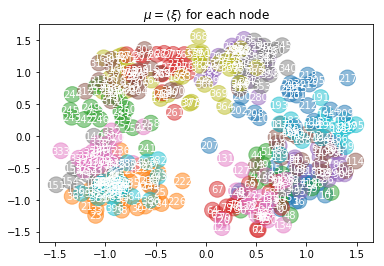

In [15]:
feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
feed_dict.update({placeholders['dropout']: 0})
emb = sess.run(model.z_mean, feed_dict=feed_dict)
plot_ξ_distribution((g, l, k), emb)